In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.nn.functional as F
import copy
from scipy.stats import ortho_group
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cpu')
#device = torch.device('cuda')
#torch.cuda.get_device_name(device)
torch.manual_seed(0)
np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])

In [3]:
path0='./'
pathAE='./'
path='./'

In [4]:
dataset_MNIST = MNIST(root=path0, download=True, transform=transform, train=True)
dataset_FMNIST = FashionMNIST(root=path0, download=True, transform=transform, train=True)
dataset_MNIST_test = MNIST(root=path0, download=True, transform=transform, train=False)
dataset_FMNIST_test = FashionMNIST(root=path0, download=True, transform=transform, train=False)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU()
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.e = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Linear(32, 16)
        )

        self.d = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(), 
            nn.Linear(32, 64),
            nn.ReLU(), 
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 3*3*32)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.dcnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.e(x)

        return x

    def decode(self, x):
        x = self.d(x)
        x = self.unflatten(x)
        x = self.dcnn(x)

        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

In [6]:
class TwoModal(Dataset):
    def __init__(self, data1, data2, idx=None):
        self.d1 = torch.empty((0, 28, 28), device=device)
        self.d2 = torch.empty((0, 28, 28), device=device)
        self.t1 = torch.empty((0, ), device=device)
        if idx is None:
            idx = np.arange(np.min((len(data1), len(data2))))

        for i in range(10):
            idx1 = (data1.targets[idx] == i)
            idx2 = (data2.targets[idx] == i)
            label_count = np.min([idx1.sum().numpy(), idx2.sum().numpy()])
            data1_c = data1.data[idx][idx1][:label_count]
            data2_c = data2.data[idx][idx2][:label_count]
            self.t1 = torch.cat((self.t1, torch.full((label_count, ), i)))
            self.d1 = torch.cat((self.d1, data1_c))
            self.d2 = torch.cat((self.d2, data2_c))
        self.t2 = torch.clone(self.t1)

    def __len__(self):
        return len(self.t1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.d1[idx], self.d2[idx], self.t1[idx], self.t2[idx]

# Train semi-supervised CLIP

In [7]:
AE_MNIST = torch.load(pathAE+'AE_MNIST')
AE_FMNIST = torch.load(pathAE+'AE_FMNIST')

In [8]:
n = 500
N = 60000 - 2*n
v = n

In [9]:
class TwoModalCompressed(TwoModal):
    def __init__(self, data1, data2, idx=None):
        super().__init__(data1, data2, idx)
        self.d1 = AE_MNIST.encode(self.d1.reshape(-1, 1, 28, 28).float()).detach()
        self.d2 = AE_FMNIST.encode(self.d2.reshape(-1, 1, 28, 28).float()).detach()

In [10]:
class DualEncoders(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16)
        )
        self.e2 = nn.Sequential(
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16)
        )

    def sim(self, x1, x2, tau=1):
        latent1, latent2 = self.e1(x1), self.e2(x2)
        latent1, latent2 = F.normalize(latent1), F.normalize(latent2)
        return latent1 @ latent2.T / tau
        
    def forward(self, x1, x2):
        x1_latent = self.e1(x1)
        x2_latent = self.e2(x2)
        return x1_latent, x2_latent

In [11]:
idx = np.random.choice(np.arange(60000), 60000)
TMC_test = TwoModalCompressed(dataset_MNIST_test, dataset_FMNIST_test)
TMC = TwoModalCompressed(dataset_MNIST, dataset_FMNIST, idx[:n])
TMC_v = TwoModalCompressed(dataset_MNIST, dataset_FMNIST, idx[n:(n+v)])
TMC_u = TwoModalCompressed(dataset_MNIST, dataset_FMNIST, idx[(n+v):(n+v+N)])

In [12]:
def get_accuracy(model, TMC_t=TMC_test):
    similarity = model.sim(TMC_t.d1.view(TMC_t.d1.size(0), -1), TMC_t.d2.view(TMC_t.d2.size(0), -1), tau=1)
    mnist_idx = torch.argmax(similarity, dim=1)
    
    return similarity, (1 - (TMC_t.t1 != TMC_t.t1[mnist_idx]).sum() / len(TMC_t))#.to('cpu').detach().numpy()

In [13]:
num_epochs = 100
tau = 1
learning_rate = 2e-3
batch_size = 64

In [14]:
dataloader = DataLoader(TMC, batch_size=batch_size, shuffle=True)

train_loss = np.empty((num_epochs,))
test_accuracy = np.empty((num_epochs,))

MMCL0 = DualEncoders()
optimizer = torch.optim.AdamW(MMCL0.parameters(), lr=learning_rate)

## Train CLIP with paired data

In [15]:
for epoch in range(num_epochs):
    for data in dataloader:
        mnist, fmnist, _, _ = data
        mnist = mnist.view(mnist.size(0), -1)
        fmnist = fmnist.view(fmnist.size(0), -1)
        
        logits = MMCL0.sim(mnist, fmnist, tau=tau)

        ## CLIP loss function
        loss1 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=1)).sum()
        loss2 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=0)).sum()

        loss = (loss1 + loss2) / 2 / len(mnist)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

    accuracy = get_accuracy(MMCL0)[1]
    print(f"[Epoch {epoch}] train loss: {loss:.3e}, test accuracy {accuracy:.3f}")
    train_loss[epoch] = loss.detach().numpy()
    test_accuracy[epoch] = accuracy.detach().numpy()

torch.save(MMCL0, path+'MMCL0')

[Epoch 0] train loss: 2.131e+00, test accuracy 0.169
[Epoch 1] train loss: 2.077e+00, test accuracy 0.174
[Epoch 2] train loss: 2.017e+00, test accuracy 0.172
[Epoch 3] train loss: 1.891e+00, test accuracy 0.205
[Epoch 4] train loss: 1.798e+00, test accuracy 0.267
[Epoch 5] train loss: 1.938e+00, test accuracy 0.330
[Epoch 6] train loss: 1.698e+00, test accuracy 0.362
[Epoch 7] train loss: 1.722e+00, test accuracy 0.372
[Epoch 8] train loss: 1.769e+00, test accuracy 0.387
[Epoch 9] train loss: 1.677e+00, test accuracy 0.398
[Epoch 10] train loss: 1.808e+00, test accuracy 0.396
[Epoch 11] train loss: 1.745e+00, test accuracy 0.406
[Epoch 12] train loss: 1.708e+00, test accuracy 0.423
[Epoch 13] train loss: 1.823e+00, test accuracy 0.440
[Epoch 14] train loss: 1.799e+00, test accuracy 0.472
[Epoch 15] train loss: 1.645e+00, test accuracy 0.464
[Epoch 16] train loss: 1.670e+00, test accuracy 0.486
[Epoch 17] train loss: 1.636e+00, test accuracy 0.500
[Epoch 18] train loss: 1.610e+00, test

In [16]:
num_epochs_u = 5
loops = 20
tau_u = 1
learning_rate = 2e-5
batch_size_u = 64
eta = 1.1

In [17]:
dataloader_u = DataLoader(TMC_u, batch_size=batch_size_u, shuffle=True)

repeated = np.empty((num_epochs_u*loops,))
#repeated2 = np.empty((num_epochs_u*loops,))
train_loss_u = np.empty((num_epochs_u*loops,))
test_accuracy_u = np.empty((num_epochs_u*loops,))

MMCL = torch.load(path+'MMCL0') # Initialize MMCL model based on MMCL with labeled data
optimizer = torch.optim.AdamW(MMCL.parameters(), lr=learning_rate)

## Train CLIP with unpaired data

In [18]:
torch.save(MMCL, path+'MMCL_best')
best_validation_accuracy = get_accuracy(MMCL0, TMC_v)[1]
for l in range(loops):
    MMCL_best = torch.load(path+'MMCL_best') # Load the best MMCL model in history
    for epoch in range(num_epochs_u):
        c = 0
        #c2 = 0
        t = 0
        #s = 0
        for data in dataloader_u:
            mnist2d, fmnist2d, t1, t2 = data
            mnist = mnist2d.view(mnist2d.size(0), -1)
            fmnist = fmnist2d.view(fmnist2d.size(0), -1)
            m = len(mnist2d)

            logits0 = MMCL_best.sim(mnist, fmnist, tau=tau).detach()
            
            optimizer.zero_grad()
            logits = MMCL.sim(mnist, fmnist, tau=tau)
            
            idx1 = torch.argmax(logits0, dim=0)
            idx2 = torch.argmax(logits0, dim=1)
            
            logits1d = logits.view(m**2)

            v1 = logits1d[idx1 + torch.arange(m)*m]
            v2 = logits1d[idx2*m + torch.arange(m)]
        
            loss1 = - v1.mean() + torch.log(torch.exp(logits).sum(axis=1)).mean()
            loss2 = - v2.mean() + torch.log(torch.exp(logits).sum(axis=0)).mean()
            loss = (loss1 + loss2) / 2

            loss.backward()
            
            optimizer.step()

            _, counts = np.unique(idx1, return_counts=True)
            c += (counts > 1).sum()
            t += m
            
        repeated[epoch+l*num_epochs_u] = c / t
        accuracy = get_accuracy(MMCL)[1]
        print(f"[Epoch {epoch}] train loss: {loss}, test accuracy {accuracy}")
        train_loss_u[epoch+l*num_epochs_u] = loss.detach().numpy()
        test_accuracy_u[epoch+l*num_epochs_u] = accuracy.detach().numpy()
    current_validation_accuracy = get_accuracy(MMCL, TMC_v)[1]
    if current_validation_accuracy > best_validation_accuracy * eta:
        best_validation_accuracy = current_validation_accuracy
        torch.save(MMCL, path+'MMCL_best') # Save the current MMCL model if it's validation accuracy is best in history

[Epoch 0] train loss: 3.467726707458496, test accuracy 0.5908440351486206
[Epoch 1] train loss: 3.254164218902588, test accuracy 0.5918658971786499
[Epoch 2] train loss: 3.321059226989746, test accuracy 0.5941140651702881
[Epoch 3] train loss: 3.2463302612304688, test accuracy 0.5961577892303467
[Epoch 4] train loss: 3.2135353088378906, test accuracy 0.6008583307266235
[Epoch 0] train loss: 3.3168535232543945, test accuracy 0.6031064987182617
[Epoch 1] train loss: 3.2550222873687744, test accuracy 0.6038217544555664
[Epoch 2] train loss: 3.243773937225342, test accuracy 0.6032086610794067
[Epoch 3] train loss: 3.310218334197998, test accuracy 0.6072961091995239
[Epoch 4] train loss: 3.323068380355835, test accuracy 0.6089311242103577
[Epoch 0] train loss: 3.2849676609039307, test accuracy 0.6101573705673218
[Epoch 1] train loss: 3.2106707096099854, test accuracy 0.6048436164855957
[Epoch 2] train loss: 3.338115930557251, test accuracy 0.604230523109436
[Epoch 3] train loss: 3.235970020

In [19]:
train_loss_u_sup = np.empty((num_epochs_u*loops,))
test_accuracy_u_sup = np.empty((num_epochs_u*loops,))

MMCL1 = torch.load(path+'MMCL0') # Initialize MMCL model based on MMCL with labeled data
optimizer = torch.optim.AdamW(MMCL1.parameters(), lr=learning_rate)

## Train oracle MMCL with the information of association in unpaired data

In [20]:
for epoch in range(num_epochs_u*loops):
    for data in dataloader_u:
        mnist, fmnist, _, _ = data
        mnist = mnist.view(mnist.size(0), -1)
        fmnist = fmnist.view(fmnist.size(0), -1)
        
        logits = MMCL1.sim(mnist, fmnist, tau=tau)

        ## CLIP loss function
        loss1 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=1)).sum()
        loss2 = - torch.diag(logits).sum() + torch.log(torch.exp(logits).sum(axis=0)).sum()

        loss = (loss1 + loss2) / 2 / len(mnist)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

    accuracy = get_accuracy(MMCL1)[1]
    print(f"[Epoch {epoch}] train loss: {loss:.3e}, test accuracy {accuracy:.3f}")
    train_loss_u_sup[epoch] = loss.detach().numpy()
    test_accuracy_u_sup[epoch] = accuracy.detach().numpy()

torch.save(MMCL1, path+'MMCL1')

[Epoch 0] train loss: 3.317e+00, test accuracy 0.603
[Epoch 1] train loss: 3.239e+00, test accuracy 0.609
[Epoch 2] train loss: 3.197e+00, test accuracy 0.621
[Epoch 3] train loss: 3.232e+00, test accuracy 0.622
[Epoch 4] train loss: 3.110e+00, test accuracy 0.632
[Epoch 5] train loss: 3.174e+00, test accuracy 0.639
[Epoch 6] train loss: 3.132e+00, test accuracy 0.645
[Epoch 7] train loss: 3.126e+00, test accuracy 0.648
[Epoch 8] train loss: 3.158e+00, test accuracy 0.650
[Epoch 9] train loss: 3.126e+00, test accuracy 0.650
[Epoch 10] train loss: 3.171e+00, test accuracy 0.649
[Epoch 11] train loss: 3.160e+00, test accuracy 0.655
[Epoch 12] train loss: 3.176e+00, test accuracy 0.658
[Epoch 13] train loss: 3.118e+00, test accuracy 0.660
[Epoch 14] train loss: 3.154e+00, test accuracy 0.663
[Epoch 15] train loss: 3.073e+00, test accuracy 0.663
[Epoch 16] train loss: 3.282e+00, test accuracy 0.658
[Epoch 17] train loss: 3.142e+00, test accuracy 0.654
[Epoch 18] train loss: 3.145e+00, test

## Plot the result

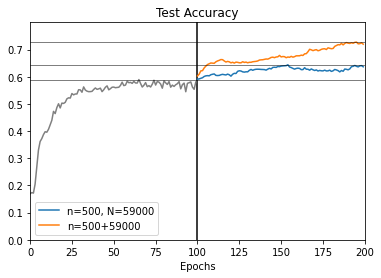

In [21]:
plt.plot(np.arange(num_epochs), test_accuracy, color="gray")
plt.plot(num_epochs+np.arange(num_epochs_u*loops), test_accuracy_u, label=f"n={n}, N={N}")
plt.plot(num_epochs+np.arange(num_epochs_u*loops), test_accuracy_u_sup, label=f"n={n}+{N}")
plt.axhline(np.max(test_accuracy), linewidth=0.5, color='black')
plt.axhline(np.max(test_accuracy_u), linewidth=0.5, color='black')
plt.axhline(np.max(test_accuracy_u_sup), linewidth=0.5, color='black')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylim(0, np.max(np.hstack([test_accuracy, test_accuracy_u, test_accuracy_u_sup]))*1.1)
plt.xlim(0, num_epochs+num_epochs_u*loops)
plt.vlines(num_epochs, 0, 10)
plt.legend()
plt.savefig(path+"Test Accuracy2c", dpi=600)

In [22]:
np.save(path+'repeated.npy', repeated)

In [23]:
repeated = np.load(path+'repeated.npy')

In [24]:
repeated.mean()

0.25444010259764854